In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import torch

from models.light_gcn import LightGCNStack
from utils.light_gcn_utils import bpr_loss, evaluate, build_user_item_interactions, get_positive_negative_ratings, recall_at_k, precision_at_k

/home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZNSt15__exception_ptr13exception_ptr9_M_addrefEv
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.preprocess import load_dataset

# Load the dataset
dataset = 'goodbooks-10k'
users, items, train_ratings, test_ratings, items_features_tensor, user_features_tensor = load_dataset(dataset)

In [3]:
num_users = users['userid'].nunique()
num_items = items['itemid'].nunique()
print(f"num_users: {num_users}, num_items: {num_items}")

num_users: 993, num_items: 754


In [4]:
# Create edge index for bipartite graph for train set
train_user_ids = train_ratings['userid'].values
train_item_ids = train_ratings['itemid'].values + num_users 
train_edge_index = torch.tensor([train_user_ids, train_item_ids], dtype=torch.long)

# Create edge index for bipartite graph for test set
test_user_ids = test_ratings['userid'].values  
test_item_ids = test_ratings['itemid'].values + num_users  
test_edge_index = torch.tensor([test_user_ids, test_item_ids], dtype=torch.long)

/tmp/ipykernel_42095/1560685500.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_edge_index = torch.tensor([train_user_ids, train_item_ids], dtype=torch.long)


In [5]:
train_user_item_dict = build_user_item_interactions(train_ratings)
test_user_item_dict = build_user_item_interactions(test_ratings)

In [6]:
positive_threshold = 5
negative_threshold = 4

In [7]:
train_user_ratings = get_positive_negative_ratings(train_user_item_dict, positive_threshold, negative_threshold)
test_user_ratings = get_positive_negative_ratings(test_user_item_dict, positive_threshold, negative_threshold)

In [8]:
for i, user in enumerate(train_user_ratings):
    train_user_ratings[i] = (user[0], [item + num_users for item in user[1]], [item + num_users for item in user[2]])

for i, user in enumerate(test_user_ratings):
    test_user_ratings[i] = (user[0], [item + num_users for item in user[1]], [item + num_users for item in user[2]])

In [9]:
embedding_dim = 384
num_nodes = num_users + num_items
no_user_features = user_features_tensor.size(1)
no_item_features = items_features_tensor.size(1)

num_layers = 10
num_epochs = 50
learning_rate = 0.0005
k = 10

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

user_features_tensor = user_features_tensor.to(device)
items_features_tensor = items_features_tensor.to(device)
train_edge_index = train_edge_index.to(device)
test_edge_index = test_edge_index.to(device)

model = LightGCNStack(num_nodes, no_user_features, no_item_features, embedding_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
embeddings = model(user_features_tensor, items_features_tensor, train_edge_index)
recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)

print("Base recall:", recall)
print("Base precision:", precision)

Base recall: 0.19513491940251873
Base precision: 0.3557611945229012


In [12]:
calc_metrics_every = 1
losses = []
recalls = []
precisions = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    pbar = tqdm(train_user_ratings, desc=f'Epoch {epoch+1}/{num_epochs}')
    embeddings = model(user_features_tensor, items_features_tensor, train_edge_index)

    for user_id, pos_items, neg_items in pbar:
        no_sample = min(len(pos_items), len(neg_items))
        users = torch.tensor([user_id] * no_sample, dtype=torch.long).to(device)
        pos_samples = random.sample(pos_items, no_sample)
        pos_samples = torch.tensor(pos_samples, dtype=torch.long).to(device)
        neg_samples = random.sample(neg_items, no_sample)
        neg_samples = torch.tensor(neg_samples, dtype=torch.long).to(device)
        
        loss = bpr_loss(embeddings, users, pos_samples, neg_samples)
        total_loss += loss
        num_batches += 1
        avg_loss = total_loss.item() / num_batches

        pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})

    total_loss.backward()
    optimizer.step()

    losses.append(total_loss)
    
    if (epoch + 1) % calc_metrics_every == 0:
        recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
        precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)
        recalls.append(recall)
        precisions.append(precision)
        avg_loss = total_loss / len(train_user_ratings)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Recall@{k}: {recall:.4f}, Precision@{k}: {precision:.4f}')
    else:
        avg_loss = total_loss / len(train_user_ratings)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    

Epoch 1/50: 100%|██████████| 961/961 [00:01<00:00, 646.74it/s, Avg Loss=4.1025]


Epoch 1/50, Loss: 4.1025, Recall@10: 0.1951, Precision@10: 0.3558


Epoch 2/50: 100%|██████████| 961/961 [00:01<00:00, 830.62it/s, Avg Loss=3.6960]


Epoch 2/50, Loss: 3.6960, Recall@10: 0.2021, Precision@10: 0.3665


Epoch 3/50: 100%|██████████| 961/961 [00:01<00:00, 509.57it/s, Avg Loss=3.3663]


Epoch 3/50, Loss: 3.3663, Recall@10: 0.2107, Precision@10: 0.3791


Epoch 4/50: 100%|██████████| 961/961 [00:01<00:00, 696.20it/s, Avg Loss=3.0835]


Epoch 4/50, Loss: 3.0835, Recall@10: 0.2254, Precision@10: 0.3983


Epoch 5/50: 100%|██████████| 961/961 [00:01<00:00, 555.34it/s, Avg Loss=2.7669]


Epoch 5/50, Loss: 2.7669, Recall@10: 0.2435, Precision@10: 0.4215


Epoch 6/50: 100%|██████████| 961/961 [00:02<00:00, 456.95it/s, Avg Loss=2.5015]


Epoch 6/50, Loss: 2.5015, Recall@10: 0.2610, Precision@10: 0.4444


Epoch 7/50: 100%|██████████| 961/961 [00:01<00:00, 673.42it/s, Avg Loss=2.2240]


Epoch 7/50, Loss: 2.2240, Recall@10: 0.2814, Precision@10: 0.4706


Epoch 8/50: 100%|██████████| 961/961 [00:01<00:00, 671.02it/s, Avg Loss=2.0423]


Epoch 8/50, Loss: 2.0423, Recall@10: 0.2995, Precision@10: 0.4950


Epoch 9/50: 100%|██████████| 961/961 [00:01<00:00, 648.58it/s, Avg Loss=1.7592]


Epoch 9/50, Loss: 1.7592, Recall@10: 0.3241, Precision@10: 0.5254


Epoch 10/50: 100%|██████████| 961/961 [00:02<00:00, 401.26it/s, Avg Loss=1.6390]


Epoch 10/50, Loss: 1.6390, Recall@10: 0.3433, Precision@10: 0.5510


Epoch 11/50: 100%|██████████| 961/961 [00:01<00:00, 668.69it/s, Avg Loss=1.4299]


Epoch 11/50, Loss: 1.4299, Recall@10: 0.3651, Precision@10: 0.5792


Epoch 12/50: 100%|██████████| 961/961 [00:01<00:00, 641.01it/s, Avg Loss=1.3021]


Epoch 12/50, Loss: 1.3021, Recall@10: 0.3853, Precision@10: 0.6062


Epoch 13/50: 100%|██████████| 961/961 [00:01<00:00, 632.38it/s, Avg Loss=1.1741]


Epoch 13/50, Loss: 1.1741, Recall@10: 0.4034, Precision@10: 0.6305


Epoch 14/50: 100%|██████████| 961/961 [00:01<00:00, 724.12it/s, Avg Loss=1.0515]


Epoch 14/50, Loss: 1.0515, Recall@10: 0.4245, Precision@10: 0.6582


Epoch 15/50: 100%|██████████| 961/961 [00:01<00:00, 721.73it/s, Avg Loss=0.9264]


Epoch 15/50, Loss: 0.9264, Recall@10: 0.4427, Precision@10: 0.6824


Epoch 16/50: 100%|██████████| 961/961 [00:01<00:00, 634.37it/s, Avg Loss=0.8467]


Epoch 16/50, Loss: 0.8467, Recall@10: 0.4586, Precision@10: 0.7045


Epoch 17/50: 100%|██████████| 961/961 [00:01<00:00, 651.01it/s, Avg Loss=0.7867]


Epoch 17/50, Loss: 0.7867, Recall@10: 0.4739, Precision@10: 0.7248


Epoch 18/50: 100%|██████████| 961/961 [00:01<00:00, 654.97it/s, Avg Loss=0.6986]


Epoch 18/50, Loss: 0.6986, Recall@10: 0.4907, Precision@10: 0.7474


Epoch 19/50: 100%|██████████| 961/961 [00:01<00:00, 613.20it/s, Avg Loss=0.6608]


Epoch 19/50, Loss: 0.6608, Recall@10: 0.4998, Precision@10: 0.7609


Epoch 20/50: 100%|██████████| 961/961 [00:01<00:00, 701.25it/s, Avg Loss=0.5903]


Epoch 20/50, Loss: 0.5903, Recall@10: 0.5126, Precision@10: 0.7797


Epoch 21/50: 100%|██████████| 961/961 [00:01<00:00, 520.90it/s, Avg Loss=0.5476]


Epoch 21/50, Loss: 0.5476, Recall@10: 0.5230, Precision@10: 0.7952


Epoch 22/50: 100%|██████████| 961/961 [00:02<00:00, 431.33it/s, Avg Loss=0.4947]


Epoch 22/50, Loss: 0.4947, Recall@10: 0.5304, Precision@10: 0.8067


Epoch 23/50: 100%|██████████| 961/961 [00:02<00:00, 404.49it/s, Avg Loss=0.4615]


Epoch 23/50, Loss: 0.4615, Recall@10: 0.5380, Precision@10: 0.8175


Epoch 24/50: 100%|██████████| 961/961 [00:01<00:00, 524.78it/s, Avg Loss=0.4137]


Epoch 24/50, Loss: 0.4137, Recall@10: 0.5457, Precision@10: 0.8289


Epoch 25/50: 100%|██████████| 961/961 [00:01<00:00, 513.01it/s, Avg Loss=0.3988]


Epoch 25/50, Loss: 0.3988, Recall@10: 0.5539, Precision@10: 0.8415


Epoch 26/50: 100%|██████████| 961/961 [00:01<00:00, 589.60it/s, Avg Loss=0.3713]


Epoch 26/50, Loss: 0.3713, Recall@10: 0.5600, Precision@10: 0.8507


Epoch 27/50: 100%|██████████| 961/961 [00:01<00:00, 566.70it/s, Avg Loss=0.3498]


Epoch 27/50, Loss: 0.3498, Recall@10: 0.5642, Precision@10: 0.8580


Epoch 28/50: 100%|██████████| 961/961 [00:01<00:00, 505.20it/s, Avg Loss=0.3217]


Epoch 28/50, Loss: 0.3217, Recall@10: 0.5685, Precision@10: 0.8653


Epoch 29/50: 100%|██████████| 961/961 [00:02<00:00, 403.46it/s, Avg Loss=0.3258]


Epoch 29/50, Loss: 0.3258, Recall@10: 0.5729, Precision@10: 0.8724


Epoch 30/50: 100%|██████████| 961/961 [00:01<00:00, 495.07it/s, Avg Loss=0.3117]


Epoch 30/50, Loss: 0.3117, Recall@10: 0.5762, Precision@10: 0.8776


Epoch 31/50: 100%|██████████| 961/961 [00:01<00:00, 494.58it/s, Avg Loss=0.2925]


Epoch 31/50, Loss: 0.2925, Recall@10: 0.5794, Precision@10: 0.8821


Epoch 32/50: 100%|██████████| 961/961 [00:01<00:00, 567.08it/s, Avg Loss=0.2793]


Epoch 32/50, Loss: 0.2793, Recall@10: 0.5808, Precision@10: 0.8847


Epoch 33/50: 100%|██████████| 961/961 [00:02<00:00, 462.43it/s, Avg Loss=0.2733]


Epoch 33/50, Loss: 0.2733, Recall@10: 0.5852, Precision@10: 0.8903


Epoch 34/50: 100%|██████████| 961/961 [00:02<00:00, 378.80it/s, Avg Loss=0.2746]


Epoch 34/50, Loss: 0.2746, Recall@10: 0.5870, Precision@10: 0.8936


Epoch 35/50: 100%|██████████| 961/961 [00:02<00:00, 461.34it/s, Avg Loss=0.2514]


Epoch 35/50, Loss: 0.2514, Recall@10: 0.5889, Precision@10: 0.8969


Epoch 36/50: 100%|██████████| 961/961 [00:02<00:00, 410.90it/s, Avg Loss=0.2463]


Epoch 36/50, Loss: 0.2463, Recall@10: 0.5920, Precision@10: 0.9017


Epoch 37/50: 100%|██████████| 961/961 [00:02<00:00, 471.38it/s, Avg Loss=0.2433]


Epoch 37/50, Loss: 0.2433, Recall@10: 0.5929, Precision@10: 0.9037


Epoch 38/50: 100%|██████████| 961/961 [00:02<00:00, 466.48it/s, Avg Loss=0.2293]


Epoch 38/50, Loss: 0.2293, Recall@10: 0.5944, Precision@10: 0.9062


Epoch 39/50: 100%|██████████| 961/961 [00:01<00:00, 621.89it/s, Avg Loss=0.2358]


Epoch 39/50, Loss: 0.2358, Recall@10: 0.5960, Precision@10: 0.9090


Epoch 40/50: 100%|██████████| 961/961 [00:01<00:00, 648.55it/s, Avg Loss=0.2297]


Epoch 40/50, Loss: 0.2297, Recall@10: 0.5975, Precision@10: 0.9118


Epoch 41/50: 100%|██████████| 961/961 [00:02<00:00, 452.90it/s, Avg Loss=0.2156]


Epoch 41/50, Loss: 0.2156, Recall@10: 0.5977, Precision@10: 0.9125


Epoch 42/50: 100%|██████████| 961/961 [00:02<00:00, 330.14it/s, Avg Loss=0.2192]


Epoch 42/50, Loss: 0.2192, Recall@10: 0.5978, Precision@10: 0.9129


Epoch 43/50: 100%|██████████| 961/961 [00:01<00:00, 516.88it/s, Avg Loss=0.2286]


Epoch 43/50, Loss: 0.2286, Recall@10: 0.5986, Precision@10: 0.9143


Epoch 44/50: 100%|██████████| 961/961 [00:01<00:00, 500.67it/s, Avg Loss=0.2021]


Epoch 44/50, Loss: 0.2021, Recall@10: 0.5986, Precision@10: 0.9144


Epoch 45/50: 100%|██████████| 961/961 [00:01<00:00, 600.62it/s, Avg Loss=0.2085]


Epoch 45/50, Loss: 0.2085, Recall@10: 0.6005, Precision@10: 0.9174


Epoch 46/50: 100%|██████████| 961/961 [00:01<00:00, 582.91it/s, Avg Loss=0.2076]


Epoch 46/50, Loss: 0.2076, Recall@10: 0.5995, Precision@10: 0.9165


Epoch 47/50: 100%|██████████| 961/961 [00:02<00:00, 401.09it/s, Avg Loss=0.2010]


Epoch 47/50, Loss: 0.2010, Recall@10: 0.6002, Precision@10: 0.9182


Epoch 48/50: 100%|██████████| 961/961 [00:01<00:00, 516.53it/s, Avg Loss=0.1951]


Epoch 48/50, Loss: 0.1951, Recall@10: 0.6011, Precision@10: 0.9200


Epoch 49/50: 100%|██████████| 961/961 [00:02<00:00, 474.18it/s, Avg Loss=0.2140]


Epoch 49/50, Loss: 0.2140, Recall@10: 0.6013, Precision@10: 0.9206


Epoch 50/50: 100%|██████████| 961/961 [00:02<00:00, 457.78it/s, Avg Loss=0.2114]


Epoch 50/50, Loss: 0.2114, Recall@10: 0.6018, Precision@10: 0.9213


In [14]:
losses = [loss.item() for loss in losses]
recalls = [recall.item() for recall in recalls]
precisions = [precision.item() for precision in precisions]

AttributeError: 'float' object has no attribute 'item'

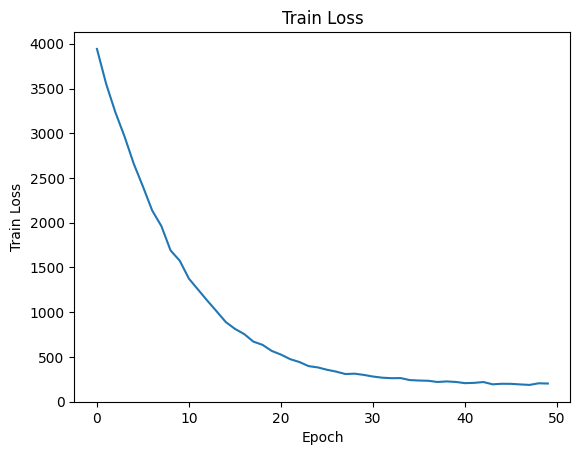

In [15]:
# make plots
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')
plt.show()

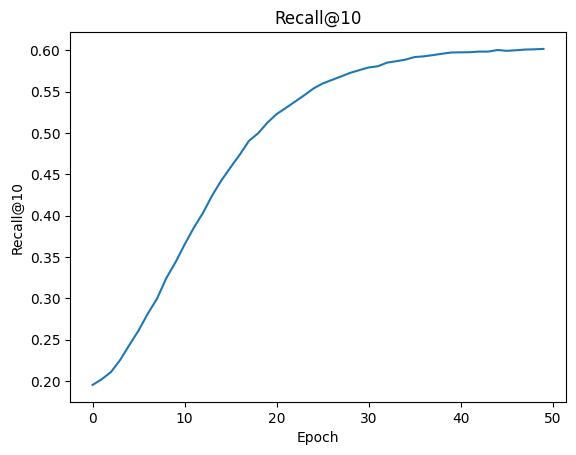

In [16]:
# Recall
plt.plot(recalls)
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.title('Recall@10')
plt.show()

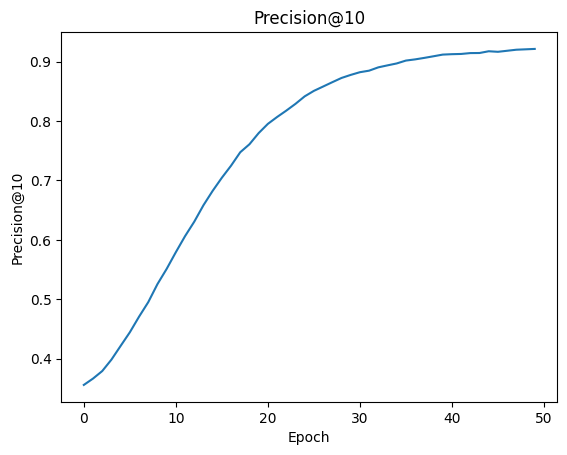

In [17]:
# Precision
plt.plot(precisions)
plt.xlabel('Epoch')
plt.ylabel('Precision@10')
plt.title('Precision@10')
plt.show()

In [ ]:
total_loss = 0
num_batches = 0
pbar = tqdm(test_user_ratings)

embeddings = model(user_features_tensor, items_features_tensor, test_edge_index)

for user_id, pos_items, neg_items in pbar:
    no_sample = min(len(pos_items), len(neg_items))
    users = torch.tensor([user_id] * no_sample, dtype=torch.long).to(device)
    pos_samples = random.sample(pos_items, no_sample)
    pos_samples = torch.tensor(pos_samples, dtype=torch.long).to(device)
    neg_samples = random.sample(neg_items, no_sample)
    neg_samples = torch.tensor(neg_samples, dtype=torch.long).to(device)
    loss = bpr_loss(embeddings, users, pos_samples, neg_samples)
    total_loss += loss
    num_batches += 1
    avg_loss = total_loss / num_batches

    # Update progress bar with average loss
    pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})
    
recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)
avg_loss = total_loss / len(test_user_ratings)
print(f'Test Loss: {avg_loss:.4f}, Test Recall@{k}: {recall:.4f}, Test Precision@{k}: {precision:.4f}')

100%|██████████| 2540/2540 [00:05<00:00, 423.88it/s, Avg Loss=4.7785]


Test Loss: 4.7785, Test Recall@10: 0.3739, Test Precision@10: 0.8034


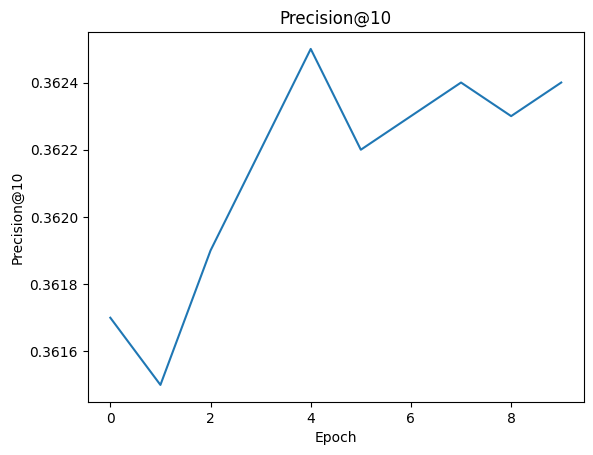

In [18]:
# Precision
precision = [0.3617, 0.3615, 0.3619, 0.3622, 0.3625, 0.3622, 0.3623, 0.3624, 0.3623, 0.3624]
recall = [0.9837, 0.9833, 0.9855, 0.9859, 0.9861, 0.9852, 0.9865, 0.9873, 0.9873, 0.9876]
plt.plot(precision)
plt.xlabel('Epoch')
plt.ylabel('Precision@10')
plt.title('Precision@10')
plt.show()

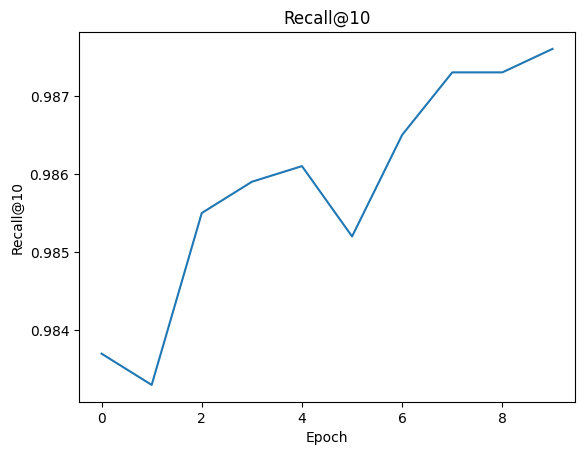

In [20]:
plt.plot(recall)
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.title('Recall@10')
plt.show()